Jesse Lunger
Cis472
Assignment: Final project results

These are the reults of my finished audio classifier, the code is a little bit messy. It was hard to neaten after I had ran it for an hour and got my results. See full report for more details.

In [ ]:
!pip install audiomentations
!pip install librosa
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0
    Uninstalling librosa-0.10.0:
      Successfully uninstalled librosa-0.10.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import os

from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#output_size = (input_size - kernel_size + 2*padding) / stride + 1

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!cd drive/MyDrive/CS472/FinalTesting/DataSets && pwd

/content/drive/MyDrive/CS472/FinalTesting/DataSets


In [ ]:
path = '/content/drive/MyDrive/CS472/FinalTesting/DataSets'

!cd path && ls

os.chdir(path)
os.listdir()

/bin/bash: line 0: cd: path: No such file or directory


['IRMAS-TrainingData']

In [ ]:
# #this allowed me to download dataset directly to google drive

# !cd /content/drive/MyDrive/CS472/FinalTesting/DataSets && wget https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1
# !cd /content/drive/MyDrive/CS472/FinalTesting/DataSets && mv 'IRMAS-TrainingData.zip?download=1' IRMAS-TrainingData.zip && unzip IRMAS-TrainingData.zip && rm -r IRMAS-TrainingData.zip


In [ ]:
! pwd

/content/drive/MyDrive/CS472/FinalTesting/DataSets


In [ ]:
!ls

IRMAS-TrainingData


In [ ]:
# used to view raw output of spectrograme before conversion, not necessary.


def get_wf_sr(file_name):
    effects = [["remix", "1"]]
    return torchaudio.sox_effects.apply_effects_file(file_name, effects=effects)

def convert_waveform_to_mfcc(waveform, sr):
    n_fft = 2048
    win_length = None
    hop_length = 512
    n_mels = 256
    n_mfcc = 128
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={
          'n_fft': n_fft,
          'n_mels': n_mels,
          'hop_length': hop_length,
          'mel_scale': 'htk',
        }
    )
    return mfcc_transform(waveform)

In [ ]:
class Cycler:
    """
    Description: simple iterator
    ARGS: no args, but in order to function must give it a list using the the toList method
    """
    def __init__(self):
      self.c = []
      self.i = 0
    def fromList(self, c_list):
        self.c = c_list
        self.i = 0
    def next(self):
      if len(self.c) <= self.i:
        return None
      else:
        item = self.c[self.i]
        self.i += 1
        return item
    def skip(self, num):
      self.i += num
    def reset(self):
      self.i = 0
    def __getitem__(self, idx):
      return self.c[idx]
    def __len__(self):
      return len(self.c)
    def toList(self):
        return self.c


Functioin below pulled from here: https://medium.com/@hasithsura/audio-classification-d37a82d6715
These functions allowed for greater detail than the ones I had been using previously,
but take up much more space in GPU. Reducing batch size is often neccessary


In [ ]:
import librosa


def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(y = wav,
                                      sr=sr,
                                      n_fft=n_fft,
                                      hop_length=hop_length,
                                      n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db


def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 50 * (spec_norm - spec_min) / (spec_max - spec_min) #change this to if too yellow
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled



In [ ]:
from re import I
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import librosa
import math
import random
import audiomentations as A
import wave
import torch.nn.functional as F

import librosa
import librosa.display
import matplotlib.pyplot as plt


class IRMASDataset(Dataset):
    def __init__(self, root_dir, included_labels = [], segment_percent= .1, n_fts=128, train_percentage= .9, noise_percentage= .1, use_random=True):
        self.root_dir = root_dir
        self.use_random = use_random #this won't work if its not random 155

        self.included_labels = included_labels


        # shift will acquire the number of splits for audio file
        self.shift = int(1/ segment_percent)   # the number of segments generated per sample
        self.segment_percent = segment_percent # Used latter to calculate the number of frames per segment
        self.num_features = n_fts              # NFT features, essentially the height of the output shape

        # datastructures
        self.file_list = []
        self.instrument_dict = {}
        self.train_data_dict = {}
        self.val_data_dict = {}
        self.test_data_dict = {}
        self.val_seg_list = []
        self.test_seg_list = []
        self.train_seg_list = []

        self.first_file = None

        #Information for dataloader partitioning
        self.val_percentage = .3 * train_percentage #change this to increase validation percentage
        self.train_percentage = train_percentage - (self.val_percentage)# change this to change everything else
        self.test_percentage = 1 - train_percentage

        # #Noise augmentation
        # self.noise_aug = A.Compose([A.AddGaussianSNR(p=noise_percentage,
        #                                       min_snr_in_db=10,
        #                                       max_snr_in_db=20)])
        #initialization functions
        self.initialize_data_structs()
        self.separate_train_test()

        #Calculate the partitions for training, validation and testing
        self.train_cut_off = int(len(self.file_list) * self.train_percentage)
        self.val_cut_off = int(len(self.file_list) * self.val_percentage) + self.train_cut_off
    def initialize_data_structs(self):
        """
        Description: collects Files from dataset and puts them into list, shuffling if If_random is used
        """
        instrument_dict = {}
        i = 0
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.wav'):
                    file_name = os.path.join(root, file)
                    parent_dir = Path(file_name).parent.name
                    if parent_dir not in self.instrument_dict and parent_dir in self.included_labels:
                        self.instrument_dict[parent_dir] = i
                        i += 1
                        self.train_data_dict[parent_dir] = []
                        self.train_data_dict[parent_dir].append(file_name); self.file_list.append(file_name)
                    elif parent_dir in self.instrument_dict:
                        self.train_data_dict[parent_dir].append(file_name); self.file_list.append(file_name)
        if self.use_random:
            for instrument in self.train_data_dict:
               random.shuffle(self.train_data_dict[instrument])
            random.shuffle(self.file_list)

    def separate_train_test(self):
      """
        Description: separates the data between training, validation and testing dictionaries
        each holding an iterator per instrument key
      """

        for instrument in self.train_data_dict:
          train_cut_off = int(len(self.train_data_dict[instrument]) * self.train_percentage)
          val_cut_off = int(len(self.train_data_dict[instrument]) * self.val_percentage) + train_cut_off
          q1 = Cycler(); q1.fromList(self.train_data_dict[instrument][:train_cut_off])
          q2 = Cycler(); q2.fromList(self.train_data_dict[instrument][train_cut_off + 1:val_cut_off])
          q3 = Cycler(); q3.fromList(self.train_data_dict[instrument][val_cut_off +1:])
          self.train_data_dict[instrument] = q1
          self.val_data_dict[instrument] = q2
          self.test_data_dict[instrument] = q3

    def get_segment_list(self, target_dict):
        """
        Description: takes one file from each instrument iterator within the target dictionary
        Converts the file into mfcc, segmenting it if neccessary, and returns a segment list
        that the dataloader will pull from
        """
        segment_list = []
        for instrument in target_dict:
            file_name = target_dict[instrument].next()
            if file_name == None:
                continue
            if self.first_file == None:
                self.first_file = file_name
            label = self.instrument_dict[instrument]
            label = torch.tensor(label)
            mfcc = get_melspectrogram_db(file_name, n_mels= self.num_features)
            mfcc = spec_to_image(mfcc)
            mfcc = mfcc[:,:400]
            mfcc = torch.tensor(mfcc, dtype=torch.float32)
            #augmented = self.noise_aug(audio)
            #audio = augmented['audio']
            num_frames = mfcc.shape[1]
            segment_length = int(num_frames * self.segment_percent)  # number of frames per chunk

            # split the tensor into segments of length segment_length along the second dimension (i.e., dim=1)
            mfcc_frames_tensor = torch.chunk(mfcc, chunks= mfcc.shape[1] // segment_length, dim=1)
            for frame in mfcc_frames_tensor:
                if frame.shape[1] == segment_length and frame.shape[0] == self.num_features:
                    segment = frame.clone().detach().float().unsqueeze(0)
                    segment_list.append( (segment, label) )

        if len(segment_list) == 0:
            self.reset_cycles(target_dict)
            return self.get_segment_list(target_dict)
        return segment_list

    def get_first_file(self):
      return self.first_file

    def reset_cycles(self, target_dict):
      """
      Resets the iterators of one target dictionary
      """
      for instrument in target_dict:
        target_dict[instrument].reset()


    def full_reset(self):
      """
      Clears semgnet pools and resets iterators
      """
      self.train_seg_list.clear()
      self.val_seg_list.clear()
      self.test_seg_list.clear()
      self.reset_cycles(self.train_data_dict)
      self.reset_cycles(self.val_data_dict)
      self.reset_cycles(self.test_data_dict)


    def __getitem__(self, idx):
        """
        Descsription: checks the range of the index request and pools from the appropriate segment list
        If the list is empty it will activate the get_segment_list method
        """
        idx = idx // self.shift
        if idx <= self.train_cut_off:
          if len(self.train_seg_list) == 0:
            self.train_seg_list = self.get_segment_list(self.train_data_dict)
          mfcc_tensor, label_tensor = self.train_seg_list.pop()
          return mfcc_tensor, label_tensor
        elif idx > self.train_cut_off and idx <= self.val_cut_off:
          if len(self.val_seg_list) == 0:
            self.val_seg_list = self.get_segment_list(self.val_data_dict)
          mfcc_tensor, label_tensor = self.val_seg_list.pop()
          return mfcc_tensor, label_tensor
        else:
          if len(self.test_seg_list) == 0:
            self.test_seg_list = self.get_segment_list(self.test_data_dict)
          mfcc_tensor, label_tensor = self.test_seg_list.pop()
          return mfcc_tensor, label_tensor


    def __len__(self):
      return len(self.file_list) * self.shift

    def increment_cycles(self, splits):
      """
      Desription: increments each iterator by a percentage of the information they carry.
      This is used for further partitioning by the dataloader
      """
      for inst in self.train_data_dict:
        increment = len(self.train_data_dict[inst]) // splits
        self.train_data_dict[inst].skip(increment)
      for inst in self.val_data_dict:
        increment = len(self.val_data_dict[inst]) // splits
        self.val_data_dict[inst].skip(increment)
      for inst in self.test_data_dict:
        increment = len(self.test_data_dict[inst]) // splits
        self.test_data_dict[inst].skip(increment)

    def get_label(self, filename):
        return self.instrument_dict[Path(filename).parent.name]

    def get_number_of_labels(self):
        return len(self.instrument_dict)

labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org", "pia"]

IRMAS_ds = IRMASDataset("IRMAS-TrainingData", included_labels= labels)



In [ ]:
# used to pad input, not actually used, but seemed like good practice
def collate_fn(batch):
  inputs, targets = zip(*batch) #separtes data and target tensors into separate lists. Target tensors are the labels
  inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True) #padd the batches with zero if they are not filled
  targets_padded = torch.stack(targets) #padds the targets with 0's until it is filled
  return inputs_padded, targets_padded

In [ ]:
from torch.utils.data import Sampler

#Sequential sampler was not working so I built my own
class StartIndexSampler(Sampler):
    """
    Description: Basic sequential sampler
    Args: start index (int), end index (int)
    """
    def __init__(self, start_index, end_index):
        self.start_index = start_index
        self.end_index = end_index
    def __iter__(self):
        return iter(range(self.start_index, self.end_index))

    def __len__(self):
        return self.end_index - self.start_index

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler, Subset

import copy

torch.manual_seed(42)


def split_samples(dataset, num_splits=10, batch_size = 64, num_workers= 2):
  """
  Description: used to split the IRMAS dataset class into training, validation and training partitions
  and then partitions those even further by the number of splits
  """
  num_files = len(dataset)
  dataset.full_reset()

  dataset_copies = []
  train_dsLoader_list = []
  val_dsLoader_list = []
  test_dsLoader_list = []
  train_percentage = dataset.train_percentage
  val_percentage = dataset.val_percentage
  test_percentage = dataset.test_percentage

  train_start = 0
  val_start = dataset.train_cut_off * dataset.shift + dataset.shift
  test_start = dataset.val_cut_off * dataset.shift + dataset.shift


  train_increment = int(train_percentage* num_files // num_splits)
  val_increment = int(val_percentage * num_files // num_splits)
  test_increment = int(test_percentage * num_files // num_splits)

  train_prev = train_start
  val_prev = val_start
  test_prev = test_start

  train_next = train_prev + train_increment
  val_next = val_prev + val_increment
  test_next = test_prev + test_increment
  print(f"split {num_files} inputs by {num_splits} splits: train size= {train_increment}, validation size= {val_increment}, test size= {test_increment}")
  skip_len = 0
  current_dataset = copy.deepcopy(dataset)
  for i in range(num_splits):
      train_dsLoader_list.append( DataLoader(current_dataset,
                                            num_workers=num_workers,
                                            batch_size= batch_size,
                                            sampler= StartIndexSampler(train_prev, train_next),
                                            collate_fn= collate_fn
                                            ) )
      train_prev = train_next
      train_next += train_increment
      #print(val_prev, val_next)
      val_dsLoader_list.append(DataLoader(current_dataset,
                                          num_workers=num_workers,
                                          batch_size= batch_size,
                                          sampler= StartIndexSampler(val_prev, val_next),
                                          collate_fn= collate_fn
                                          ) )
      val_prev = val_next + 1
      val_next += val_increment
      test_dsLoader_list.append( DataLoader(current_dataset,
                                            num_workers=num_workers,
                                            batch_size= batch_size,
                                            sampler= StartIndexSampler(test_prev, test_next),
                                            collate_fn= collate_fn
                                            ) )
      test_prev = test_next + 1
      test_next += test_increment
      dataset_copies.append(current_dataset)
      current_dataset = copy.deepcopy(current_dataset)
      current_dataset.increment_cycles(num_splits)

  return train_dsLoader_list, val_dsLoader_list, test_dsLoader_list, dataset_copies



Test function to show how the iterator was splitting the data

In [ ]:
from typing_extensions import dataclass_transform
batch_size = 1
train_dsLoader_list, val_dsLoader_list, test_dsLoader_list, dataset_copies = split_samples(IRMAS_ds, num_splits = 1, batch_size= batch_size) #dataset, num_workers =2, num_splits, batch_size = 2


#data, label = next(iter(test_dsLoader_list[0]))
# data1, label1 = next(iter(train_dsLoader_list[5]))
# print(data[0][0][30])
# print(data1[0][0][30])


split 67050 inputs by 1 splits: train size= 42241, validation size= 18103, test size= 6704


Test to show the data sets are not equal, each time it a dataloader
is called it copies the current dataset state it is assigned to by
making copies it refers to the state of the copy.

Copy of output:

tensor([0.1227, 0.0205, 0.0053, 0.1575, 0.1030, 0.0833, 0.1713, 0.1905, 0.1395, 0.1874, 0.1687, 0.0704, 0.0523])

tensor([-0.4809, -0.5016, -0.5025, -0.4433, -0.3915, -0.3718, -0.2472, -0.2602, -0.2802, -0.2363, -0.1246, -0.1997, -0.1865])

Further validation that data was correctly divided

In [ ]:
sample_idx = 0 # index of the sample to retrieve
print(f"Number of instruments: {len(IRMAS_ds.instrument_dict)}\n")
#print(IRMAS_ds.data_dict.keys())
print(f"Shape of output: {IRMAS_ds[0][0].shape} \n")  #torch.Size([1, 50, 13])
print(f"Number of wave files: {len(IRMAS_ds) // 10}\n")

#if you set segment_percentage to .1 the resulting shape will be 26 by 26.


train_keys = "Train keys: "
for key in IRMAS_ds.train_data_dict:
  train_keys += (f" {key}:{len(IRMAS_ds.train_data_dict[key])}")
print(train_keys)

val_keys = "\nVal keys: "
for key in IRMAS_ds.train_data_dict:
  val_keys += (f" {key}:{len(IRMAS_ds.val_data_dict[key])}")
print(val_keys)

test_keys = "\nTest keys: "
for key in IRMAS_ds.test_data_dict:
  test_keys += f" {key}:{len(IRMAS_ds.test_data_dict[key])} "
print(test_keys)




Number of instruments: 11

Shape of output: torch.Size([1, 128, 40]) 

Number of wave files: 6705

Train keys:  sax:394 tru:363 vio:365 voi:490 cel:244 cla:318 flu:284 gac:401 gel:478 org:429 pia:454

Val keys:  sax:168 tru:154 vio:155 voi:209 cel:103 cla:135 flu:120 gac:170 gel:204 org:183 pia:193

Test keys:  sax:62  tru:58  vio:58  voi:77  cel:39  cla:50  flu:45  gac:64  gel:76  org:68  pia:72 


Code used to view the spectrogram. In ths implementation I had been using differen't filters

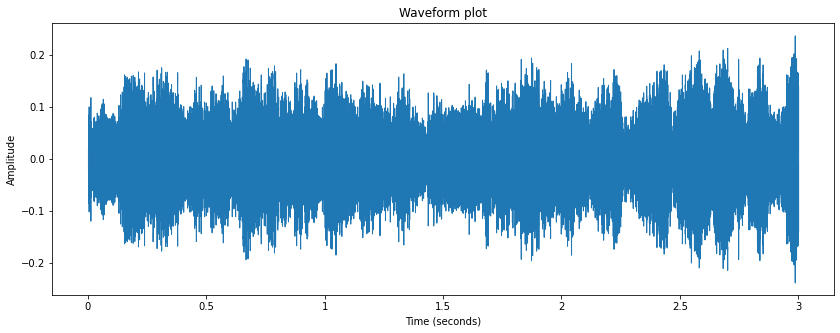

(128, 431)


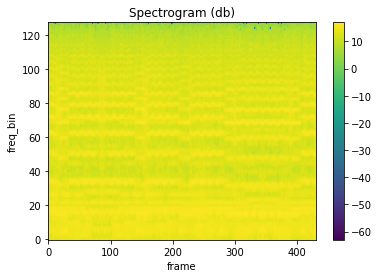

     View of Working SpectroGram
tensor(10)
torch.Size([1, 128, 40])


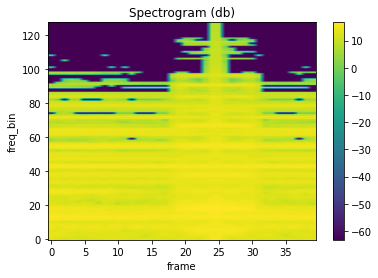


   View of full spectroGram


/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


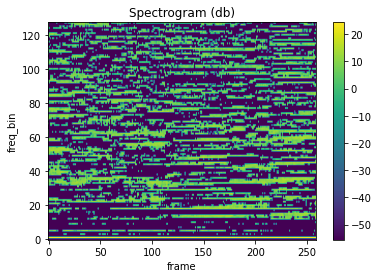

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random

import torchaudio
import torchaudio.transforms as T

file_name = IRMAS_ds.file_list[random.randint(0, len(IRMAS_ds.file_list) - 1)]
# load audio file
audio, sr = librosa.load(file_name)

# plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform plot')
plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

spec_db = get_melspectrogram_db(file_name)
spec_db = spec_to_image(spec_db)
print(spec_db.shape)
plot_spectrogram(spec_db)




print("     View of Working SpectroGram")
item = IRMAS_ds[0]
print(item[1])
print(item[0].shape)
plot_spectrogram(item[0][0])

file_name = IRMAS_ds.get_first_file()


print("\n   View of full spectroGram")
wf, sr = get_wf_sr(file_name)
mfcc = convert_waveform_to_mfcc(wf, sr)
plot_spectrogram(mfcc[0])


# for instrument in IRMAS_ds.train_data_dict:
#   # sample = cycle.next()
#   print(instrument)
#   file_name = IRMAS_ds.train_data_dict[instrument].next()
#   wf, sr = get_wf_sr(file_name)
#   mfcc = convert_waveform_to_mfcc(wf, sr)
#   plot_spectrogram(mfcc[0])



output_length = (input_length + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1

output_shape = (batch_size, out_channels, output_length)


Resnet inspired by Hale J

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, inChannels, outChannels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inChannels,
                               outChannels,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn = nn.BatchNorm2d(outChannels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=11, dropout_prob=0.5):
        super(ResNet, self).__init__()
        self.inChannels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, outChannels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inChannels != outChannels:
            downsample = nn.Sequential(
                nn.Conv2d(self.inChannels, outChannels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outChannels),
            )

        layers = []
        layers.append(block(self.inChannels, outChannels, stride, downsample))
        self.inChannels = outChannels
        for i in range(1, blocks):
            layers.append(block(self.inChannels, outChannels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
class tmp_ds(Dataset):
    def __init__(self, val_images, val_labels):
        self.images = val_images
        self.labels = val_labels

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm # This is optional but useful
import gc

CUDA_LAUNCH_BLOCKING=1

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



class Trainer():
    def __init__(self, model, dataset, num_splits= 20, batch_size=512, num_epochs= 10, num_workers= 1):
        #hyper Parameters
        self.num_epochs = num_epochs
        self.lr = .001
        self.batch_size = (batch_size // dataset.shift) * dataset.shift  #ensures that each batch size does not cut between instruments
        self.num_splits = num_splits

        self.train_list, self.val_list, self.test_list, self.dataset_copies = split_samples(dataset,
                                                                                            num_splits = self.num_splits,
                                                                                            batch_size= self.batch_size,
                                                                                            num_workers= num_workers)

        self.training_data = []
        self.training_labels = []
        self.testing_data = []
        self.testing_labels = []


        self.dataset = dataset
        self.total_loss = []
        self.total_val_loss = []

        self.reuse_val_dataset = None
        self.reuse_val_loader = None

        self.num_labels = dataset.get_number_of_labels()
        self.num_channels = 0
        self.num_frames = 0
        self.num_features =  0
        self.get_data_info()
        self.model = model
        #self.model = model(ResBlock, [3,4,6,3], num_classes= num_labels).to(device)
        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay= .001, momentum= .09)
        #weight decay is done to prevent overfitting, it does this by adding a penalty to the loss function to make it have smaller values
        #momentum helps smooth out the update process and make learning happen quicker

    def get_data_info(self):
        extract_mfcc_tensor, label = self.dataset[0]
        self.num_channels, self.num_frames, self.num_features = extract_mfcc_tensor.shape

    def train_over_partition(self, partition_num):
        if partition_num > self.num_splits or partition_num < 0:
            print(f"num_partition must be >=0 and  < {self.num_splits}")
        train_loader = self.train_list[partition_num]
        valid_loader = self.val_list[partition_num]
        test_loader = self.test_list[partition_num]

        self.model.train()
        loss_history = []
        val_loss_history = []
        loss = torch.Tensor([0])

        start_time = time.time()
        reuse_images = []
        reuse_labels = []
        first_pass = True
        for epoch in tqdm(range(self.num_epochs), desc=f"Epoch", unit="epoch", disable=False):
            #train on train data
            for (images, labels) in tqdm(train_loader, desc="iteration", unit="%", disable=True):
                self.optimizer.zero_grad(set_to_none=True)
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                loss_history.append(loss.item())
                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()
            # Validation
            self.model.eval()
            with torch.no_grad():
                for (images, labels) in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    if first_pass:
                        reuse_images.extend(images)
                        reuse_labels.extend(labels)
                    val_loss = self.criterion(outputs, labels)
                    val_loss_history.append(val_loss.item())
            first_pass = False
            self.model.train()

            # Print epoch and losses
            avg_train_loss = sum(loss_history) / len(loss_history)
            avg_val_loss = sum(val_loss_history) / len(val_loss_history)
            print(f"Epoch {epoch}: train_loss: {avg_train_loss:.5f}, val_loss: {avg_val_loss:.5f}") # glitch in which it doesn't print last print output

        #Train on validation data
        print("\nTraining over Validation set:")
        for epoch in tqdm(range(int(self.num_epochs) * self.dataset.val_percentage), desc=f"Epoch", unit="epoch", disable=False):
            self.reuse_val_data(reuse_images, reuse_labels)
            for (images, labels) in tqdm(self.reuse_val_loader, desc="iteration", unit="%", disable=True):
                self.optimizer.zero_grad(set_to_none=True)
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                loss_history.append(loss.item())
                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()
            avg_train_loss = sum(loss_history) / len(loss_history)
            print(f"Epoch {epoch}: train_loss: {avg_train_loss:.5f}")
        end_time = time.time()
        print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

        self.total_loss.extend(loss_history)
        self.total_val_loss.extend(val_loss_history)
        plt.plot(self.total_loss, label='Training set')
        plt.plot(self.total_val_loss, label='Validation set')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        correct = 0
        total = 0
        with torch.no_grad():
          for data in self.test_list[partition_num]:
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = self.model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
        print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")

    def get_eval_data_over_range(self, start, end):
        #collecting training data
        print("\nCollecting output data for training")
        with torch.no_grad():
          for i in range(start, end):
              for data in self.train_list[i]:
                  inputs, labels = data
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = self.model(inputs)
                  self.collect_training_data(outputs, labels)
              for data in self.val_list[i]:
                  inputs, labels = data
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = self.model(inputs)
                  self.collect_training_data(outputs, labels)
              for data in self.test_list[i]:
                  inputs, labels = data
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = self.model(inputs)
                  self.collect_training_data(outputs, labels, if_test=True)


    def collect_training_data(self, outputs, labels, if_test=False):
        tmp_list = []
        for i, output in enumerate(F.softmax(outputs, dim=1)):
            tmp_list.append(output)
            if (i + 1) % self.dataset.shift == 0:
              if if_test == True:
                  self.testing_labels.append(labels[i].to("cpu"))
                  self.testing_data.append(torch.stack(tmp_list).unsqueeze(0).to("cpu"))
              else:
                  self.training_labels.append(labels[i].to("cpu"))
                  self.training_data.append(torch.stack(tmp_list).unsqueeze(0).to("cpu"))
              tmp_list.clear()


    def get_training_data(self):
        return self.training_data, self.training_labels, self.testing_data, self.testing_labels


    def reuse_val_data(self,images, labels):
        self.reuse_val_dataset = tmp_ds(images, labels)
        self.reuse_val_loader = DataLoader(self.reuse_val_dataset, batch_size= self.batch_size, shuffle=True)

        # temp = list(zip(images, labels))
        # random.shuffle(temp)
        # r_images, r_labels = zip(*temp)


    def only_test(self):
        correct = 0
        total = 0
        with torch.no_grad():
          for test_partition in self.test_list:
            for data in test_partition:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")

    def train_over_range(self, start, end):
        for i in range(start, end + 1):
            print(f"\npartition: {i}/{end}\n")
            self.train_over_partition(i)
        self.get_eval_data_over_range(start, end + 1)



split 67050 inputs by 1 splits: train size= 42241, validation size= 18103, test size= 6704

partition: 0/0



Epoch:  10%|█         | 1/10 [24:06<3:37:02, 1446.95s/epoch]

Epoch 0: train_loss: 2.48655, val_loss: 2.64806


Epoch:  20%|██        | 2/10 [27:26<1:35:03, 712.96s/epoch] 

Epoch 1: train_loss: 2.42794, val_loss: 2.59366


Epoch:  30%|███       | 3/10 [30:46<55:52, 478.92s/epoch]  

Epoch 2: train_loss: 2.37541, val_loss: 2.55140


Epoch:  40%|████      | 4/10 [34:11<37:05, 370.94s/epoch]

Epoch 3: train_loss: 2.32796, val_loss: 2.52760


Epoch:  50%|█████     | 5/10 [37:35<25:53, 310.70s/epoch]

Epoch 4: train_loss: 2.28292, val_loss: 2.51289


Epoch:  60%|██████    | 6/10 [41:00<18:18, 274.61s/epoch]

Epoch 5: train_loss: 2.24186, val_loss: 2.50359


Epoch:  70%|███████   | 7/10 [44:27<12:37, 252.53s/epoch]

Epoch 6: train_loss: 2.20311, val_loss: 2.49928


Epoch:  80%|████████  | 8/10 [47:52<07:54, 237.32s/epoch]

Epoch 7: train_loss: 2.16519, val_loss: 2.49491


Epoch:  90%|█████████ | 9/10 [51:20<03:48, 228.18s/epoch]

Epoch 8: train_loss: 2.12780, val_loss: 2.49401


Epoch: 100%|██████████| 10/10 [54:46<00:00, 328.66s/epoch]


Epoch 9: train_loss: 2.09054, val_loss: 2.49510

Training over Validation set:


Epoch:  10%|█         | 1/10 [00:18<02:42, 18.07s/epoch]

Epoch 0: train_loss: 2.08554


Epoch:  20%|██        | 2/10 [00:36<02:25, 18.22s/epoch]

Epoch 1: train_loss: 2.07569


Epoch:  30%|███       | 3/10 [00:54<02:06, 18.08s/epoch]

Epoch 2: train_loss: 2.06351


Epoch:  40%|████      | 4/10 [01:12<01:48, 18.01s/epoch]

Epoch 3: train_loss: 2.04939


Epoch:  50%|█████     | 5/10 [01:30<01:29, 17.95s/epoch]

Epoch 4: train_loss: 2.03338


Epoch:  60%|██████    | 6/10 [01:48<01:11, 17.97s/epoch]

Epoch 5: train_loss: 2.01612


Epoch:  70%|███████   | 7/10 [02:06<00:53, 17.97s/epoch]

Epoch 6: train_loss: 1.99764


Epoch:  80%|████████  | 8/10 [02:23<00:35, 17.96s/epoch]

Epoch 7: train_loss: 1.97787


Epoch:  90%|█████████ | 9/10 [02:41<00:17, 17.93s/epoch]

Epoch 8: train_loss: 1.95704


Epoch: 100%|██████████| 10/10 [03:00<00:00, 18.01s/epoch]

Epoch 9: train_loss: 1.93529
Total training time: 57.78 minutes


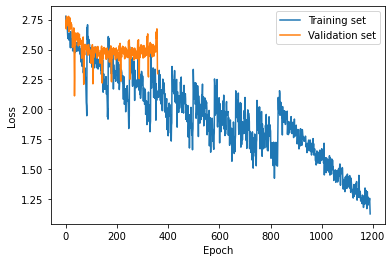

Accuracy of the network on the test set: 37.65%




In [ ]:
# model = LinearNet().to(device)
#model = CNNModel(11).to(device)
model = ResNet(ResBlock, [3, 4, 6, 3]).to(device)


labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org", "pia"]
IRMAS_ds = IRMASDataset("IRMAS-TrainingData", segment_percent= .1, included_labels= labels)


trainer = Trainer(model, IRMAS_ds, num_splits= 1, num_epochs= 10)
trainer.train_over_range(0,0)



In [ ]:
data, labels, test_data, test_labels = trainer.get_training_data()
results_ds = tmp_ds(data, labels)
test_ds = tmp_ds(test_data, test_labels)

print("checking training data")
print(len(data))
print(len(labels))

print("checking testing data")
print(len(test_data))
print(len(test_labels))

# print(results_ds[0][0])






checking training data
6034
6034
checking testing data
670
670


In [ ]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler


# Define indices for train, validation, and test splits
num_samples = len(results_ds)
num_test_samples = len(test_ds)

train_split = int(num_samples * 0.9)
val_split = num_samples - train_split

train_indices = list(range(train_split))
val_indices = list(range(train_split, train_split + val_split))
test_indices = list(range(0, num_test_samples))

# Define samplers for each split
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define data loaders for each split
batch_size = 64
train_loader = DataLoader(results_ds, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(results_ds, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler)


#print(next(iter(train_loader))[0].shape)


In [ ]:

# model =  LinearNet(
#                  ninputs= 10 * 11,   # number of inputs (30x30)
#                  nhidden=100,   # number of nodes in hidden layer
#                  nout=11,       # output
#                  nLayers = 1,
#                  channels = 1,
#                  dropout_prob=0.1
#                 ).to(device)


model = ResNet(ResBlock, [3, 4, 6, 3]).to(device)

num_epochs = 100 #50 looks optimal

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= .001, weight_decay= .001, momentum= .09)

model.train()
loss_history = []
val_loss_history = []
loss = torch.Tensor([0])

reuse_images = []
reuse_labels = []
first_pass = True
start_time = time.time()
for epoch in tqdm(range(num_epochs), desc=f"Epoch", unit="epoch", disable=False):
    #train on train data
    for (images, labels) in tqdm(train_loader, desc="iteration", unit="%", disable=True):
        optimizer.zero_grad(set_to_none=True)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    # Validation
    model.eval()
    with torch.no_grad():
        for (images, labels) in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_loss_history.append(val_loss.item())
    model.train()
    avg_train_loss = sum(loss_history) / len(loss_history)
    avg_val_loss = sum(val_loss_history) / len(val_loss_history)
    print(f"Epoch {epoch}: train_loss: {avg_train_loss:.5f}, val_loss: {avg_val_loss:.5f}") # glitch in which it doesn't print last print output

#Train on validation data
print("\nTraining over Validation set:")
for epoch in tqdm(range(num_epochs//3), desc=f"Epoch", unit="epoch", disable=False):
    for (images, labels) in tqdm(val_loader, desc="iteration", unit="%", disable=True):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    avg_train_loss = sum(loss_history) / len(loss_history)
    print(f"Epoch {epoch}: train_loss: {avg_train_loss:.5f}")

#total_loss.extend(loss_history)
#total_val_loss.extend(val_loss_history)
plt.plot(loss_history, label='Training set')
plt.plot(val_loss_history, label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


end_time = time.time() # End time
print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

correct = 0
total = 0
with torch.no_grad():
  for (images, labels) in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")

Epoch:   1%|          | 1/100 [00:17<28:13, 17.10s/epoch]

Epoch 0: train_loss: 1.95717, val_loss: 2.05387


Epoch:   2%|▏         | 2/100 [00:32<26:28, 16.21s/epoch]

Epoch 1: train_loss: 1.75560, val_loss: 2.03501


Epoch:   3%|▎         | 3/100 [00:48<25:56, 16.04s/epoch]

Epoch 2: train_loss: 1.63792, val_loss: 2.01252


Epoch:   4%|▍         | 4/100 [01:04<25:26, 15.90s/epoch]

Epoch 3: train_loss: 1.55475, val_loss: 2.01539


Epoch:   5%|▌         | 5/100 [01:20<25:06, 15.86s/epoch]

Epoch 4: train_loss: 1.49175, val_loss: 2.01736


Epoch:   6%|▌         | 6/100 [01:35<24:42, 15.77s/epoch]

Epoch 5: train_loss: 1.43981, val_loss: 2.00415


Epoch:   7%|▋         | 7/100 [01:51<24:23, 15.74s/epoch]

Epoch 6: train_loss: 1.39084, val_loss: 1.98989


Epoch:   8%|▊         | 8/100 [02:06<24:05, 15.71s/epoch]

Epoch 7: train_loss: 1.34600, val_loss: 1.98113


Epoch:   9%|▉         | 9/100 [02:22<23:51, 15.73s/epoch]

Epoch 8: train_loss: 1.30251, val_loss: 1.96955


Epoch:  10%|█         | 10/100 [02:38<23:31, 15.68s/epoch]

Epoch 9: train_loss: 1.26454, val_loss: 1.97208


Epoch:  11%|█         | 11/100 [02:54<23:28, 15.83s/epoch]

Epoch 10: train_loss: 1.22456, val_loss: 1.97142


Epoch:  12%|█▏        | 12/100 [03:10<23:31, 16.04s/epoch]

Epoch 11: train_loss: 1.18471, val_loss: 1.97214


Epoch:  12%|█▏        | 12/100 [03:11<23:27, 15.99s/epoch]


KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for (images, labels) in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")

Accuracy of the network on the test set: 47.16%



In [ ]:
# model = CNN(11).to(device)
# trainer = Trainer(model, IRMAS_ds, num_splits= 5, num_epochs= 10)
# trainer.train_over_range(0, 4) #error here, original had set to 5, but that would be 6 partitions

In [ ]:
#model = ResNet(ResBlock, [2, 2, 2, 2]).to(device) #68%
# labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org", "pia"]
# import torch.nn as nn

# import torch.nn as nn

# Define the CNN model



# train_labels = []
# for label in labels:
#     train_labels.append(label)
#     if len(train_labels) == 2:

#         train_labels.clear()


In [ ]:
# labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org"] # no piano
# IRMAS_ds = IRMASDataset("IRMAS-TrainingData", included_labels= labels)
# trainer = Trainer(model, IRMAS_ds, num_splits= 10, num_epochs= 10)
# trainer.only_test()

In [ ]:

        # temp = list(zip(images, labels))
        # random.shuffle(temp)
        # r_images, r_labels = zip(*temp)